In [1]:
import csv
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
df = pd.read_csv("../../data/data7size20.csv")
y = df['class']

In [2]:
img_list = []
size = 64
for i in range(len(df)):
    #img_list.append(cv2.resize(cv2.imread("../../"+df.PATH[i]),(size,size)))
    img_data = cv2.imread("../../"+df.PATH[i])
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)  
    img_data = cv2.resize(img_data,(size,size))
    img_list.append(img_data)
    
X_train, X_test, y_train, y_test = train_test_split(img_list, y, test_size=0.2,random_state=1)
X_test,X_val,y_test,y_val = train_test_split(X_test, y_test, test_size=0.5,random_state=1)

In [5]:
'''
np.save("X_train",np.array(X_train))
np.save("X_val",np.array(X_val))
np.save("X_test",np.array(X_test))
np.save("y_train",np.array(y_train))
np.save("y_val",np.array(y_val))
np.save("y_test",np.array(y_test))
'''
X_train.shape

(36284, 64, 64)

In [4]:
from tensorflow.keras.utils import to_categorical
X_train,X_val,X_test = np.array(X_train)/255.,np.array(X_val)/255.,np.array(X_test)/255.
#y_train,y_val,y_test =  to_categorical((np.array(y_train)),7),to_categorical((np.array(y_val)),7),to_categorical((np.array(y_test)),7)

y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [6]:
import tensorflow as tf
def make_example(image, label):
    return tf.train.Example(features=tf.train.Features(feature={
        'x' : tf.train.Feature(float_list=tf.train.FloatList(value=image)),
        'y' : tf.train.Feature(int64_list=tf.train.Int64List(value=label))
    }))

def write_tfrecord(images, labels, filename):
    writer = tf.io.TFRecordWriter(filename)
    for image, label in zip(images, labels):
        ex = make_example(image.ravel().tolist(), [int(label)])
        writer.write(ex.SerializeToString())
    writer.close()

write_tfrecord(X_train, y_train, 'mnist_train.tfrecord')
write_tfrecord(X_test, y_test, 'mnist_test.tfrecord')
write_tfrecord(X_val, y_val, 'mnist_val.tfrecord')

In [7]:
from tensorflow.keras import layers,models,initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
import sys
def make_model():
    size = 64
    factor=1e-5
    model = models.Sequential()
    model.add(layers.Conv2D(8, (5, 5), activation='relu', kernel_regularizer=l2(factor),input_shape=(size, size, 1)))
    model.add(layers.MaxPooling2D((2, 2)))


    model.add(layers.Conv2D(16, (5, 5), activation='relu',kernel_regularizer=l2(factor)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(factor)))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=l2(factor)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=l2(factor)))
    model.add(layers.Dense(128, activation='relu',kernel_regularizer=l2(factor)))
    
    model.add(layers.Dense(7, activation='softmax'))
    #model.summary()
    return model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


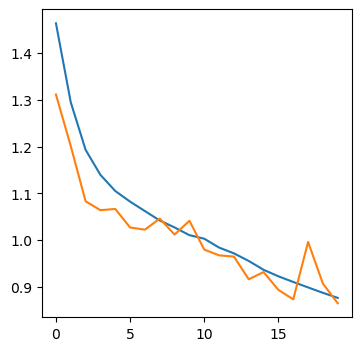

In [9]:
def parse_features(example):
    features = tf.io.parse_single_example(example, features={
        'x' : tf.io.FixedLenFeature([64, 64,1], tf.float32),
        'y' : tf.io.FixedLenFeature([1], tf.int64),
    })
    x = features['x']
    y = features['y']
    return x, y
import matplotlib.pyplot as plt
train_dataset = tf.data.TFRecordDataset(filenames='mnist_train.tfrecord')
train_dataset = train_dataset.map(parse_features).shuffle(60000).batch(512)

val_dataset = tf.data.TFRecordDataset(filenames='mnist_val.tfrecord')
val_dataset = val_dataset.map(parse_features).shuffle(12000).batch(512)

test_dataset = tf.data.TFRecordDataset(filenames='mnist_test.tfrecord')
test_dataset = test_dataset.map(parse_features).shuffle(12000).batch(512)

model = make_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
hist = model.fit(train_dataset, validation_data=val_dataset,
                 epochs=20, verbose=False)

plt.figure(figsize=(4, 4))
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.show()

In [10]:
score = model.evaluate(test_dataset, verbose=0,batch_size=128)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8691842555999756
Test accuracy: 0.6826902031898499


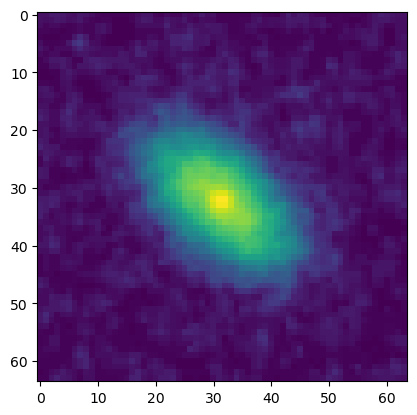

In [14]:
plt.imshow(img_data)
plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit